# Case study: predictive maintenance for engines.

 Michas Works is a European manufacturing company that supplies automotive components in high volumes across the continent. The vehicles using these components generally follow fixed maintenance schedules.

Currently, the industry is undergoing deep transformations, and efforts for implementing predictive maintenance use cases are being made. Various initiatives within the company are focused on reducing costs, providing a better experience for end customers as well as increasing the reliability of products delivered.

 

We’ve attached a dataset related to Predictive Maintenance, containing readings from various engine types along with associated failure events. We’d like to see how you approach this task using data science techniques, as well as how you derive insights and make data-driven decisions based on the results. The goal is to generate outcomes that can help inform customers—ideally in advance—and support long-term product development planning.

 

The end deliverable should be a project presentation that outlines your solution, including system integration within an enterprise architecture, key data engineering and machine learning components, and the expected business value. Please also include one slide to support a high-level overview of the system and its potential impact.

In [179]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import joblib # For saving the model and pipeline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [180]:
# --- Configuration ---
DATA_FILE = 'predictive_maintenance.csv' # Replace with your actual data file path
TARGET_COLUMN = 'Target' # The column indicating failure (1) or no failure (0)
# Columns to drop (identifiers or irrelevant features)
DROP_COLUMNS = ['UDI', 'Product ID', 'Failure Type']
# Categorical features to encode
CATEGORICAL_FEATURES = ['Type']
# Numerical features to scale
NUMERICAL_FEATURES = [
    'Air temperature [K]', # Assuming K, adjust if C
    'Process temperature [K]', # Assuming K, adjust if C
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]'
]
TEST_SIZE = 0.2 # Proportion of data to use for testing
RANDOM_STATE = 42 # For reproducibility

In [181]:
def load_data(file_path):
    """Loads data from a CSV file."""
    print(f"Loading data from {file_path}...")
    try:
        df = pd.read_csv(file_path)
        # Basic cleaning: Remove potential leading/trailing spaces in column names
        df.columns = df.columns.str.strip()
        print("Data loaded successfully.")
        # Convert temperature from C to K if necessary (example)
        # Check if columns exist before conversion
        if 'Air temperature [°C]' in df.columns:
            df['Air temperature [K]'] = df['Air temperature [°C]'] + 273.15
            df.drop('Air temperature [°C]', axis=1, inplace=True)
        if 'Process temperature [°C]' in df.columns:
            df['Process temperature [K]'] = df['Process temperature [°C]'] + 273.15
            df.drop('Process temperature [°C]', axis=1, inplace=True)
        print("Columns available:", df.columns.tolist())
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

In [182]:
def create_preprocessing_pipeline(numerical_features, categorical_features):
    """Creates a preprocessing pipeline for numerical and categorical features."""
    print("Creating preprocessing pipeline...")

    # Define transformers for numerical and categorical features
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore') # Ignore categories not seen during training

    # Create a column transformer to apply different transformations to different columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough' # Keep other columns not specified (if any) - adjust if needed
    )
    print("Preprocessing pipeline created.")
    return preprocessor

In [183]:
def train_model(X_train, y_train, preprocessor):
    """Trains a RandomForestClassifier model using a pipeline."""
    print("Training model...")

    # Define the model    

    pipeline_smote = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('classifier', XGBClassifier(random_state=RANDOM_STATE))
    ])
    
    pipeline.fit(X_train, y_train)
    print("Model training complete.")
    return pipeline

In [184]:
def evaluate_model(pipeline, X_data, y_data, dataset_name="Test", save_plot=True):
    """Evaluates the trained model and plots a confusion matrix."""
    print(f"\n--- Model Evaluation on {dataset_name} Set ---")
    y_pred = pipeline.predict(X_data)
    y_pred_proba = pipeline.predict_proba(X_data)[:, 1]

    # --- Print Metrics ---
    print(f"Accuracy ({dataset_name}):", accuracy_score(y_data, y_pred))
    try:
        print(f"ROC AUC Score ({dataset_name}):", roc_auc_score(y_data, y_pred_proba))
    except ValueError as e:
        print(f"Could not calculate ROC AUC for {dataset_name} set: {e}")
    print(f"\nClassification Report ({dataset_name}):\n", classification_report(y_data, y_pred))

    # --- Confusion Matrix Calculation & Plotting ---
    cm = confusion_matrix(y_data, y_pred)
    print(f"\nConfusion Matrix ({dataset_name}):\n", cm)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=True,
                xticklabels=['Predicted No Failure', 'Predicted Failure'],
                yticklabels=['Actual No Failure', 'Actual Failure'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {dataset_name} Set')

    plt.show()
    print("------------------------")

In [185]:
# --- 5. Save Pipeline ---
def save_pipeline(pipeline, file_path):
    """Saves the trained pipeline (including preprocessor and model) to a file."""
    print(f"Saving pipeline to {file_path}...")
    joblib.dump(pipeline, file_path)
    print("Pipeline saved successfully.")

Loading data from predictive_maintenance.csv...
Data loaded successfully.
Columns available: ['UDI', 'Product ID', 'Type', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target', 'Failure Type', 'Air temperature [K]', 'Process temperature [K]']

Using features: ['Type', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Air temperature [K]', 'Process temperature [K]']
Numerical features: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
Categorical features: ['Type']

Splitting data into train/test sets (Test size: 0.2)...
Data split complete.
Training set shape: (8000, 6), Test set shape: (2000, 6)
Creating preprocessing pipeline...
Preprocessing pipeline created.
Training model...
Model training complete.

--- Model Evaluation on Test Set ---
Accuracy (Test): 0.9835
ROC AUC Score (Test): 0.9685406771404214

Classification Report (Test):
               precision    recall  f1-score   support

        

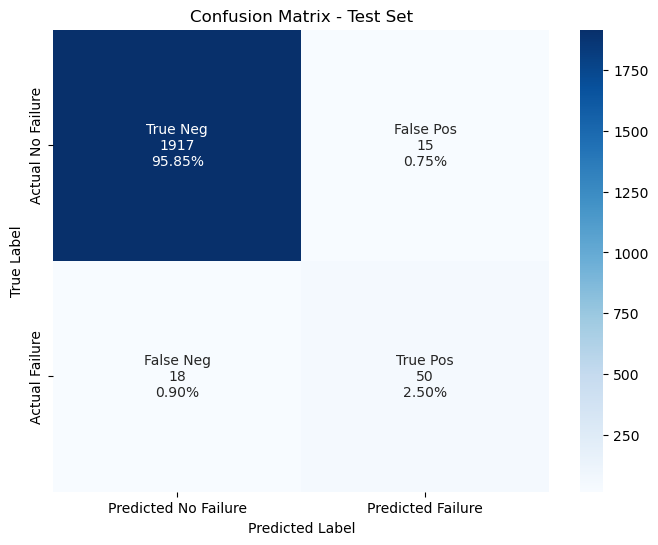

------------------------
Saving pipeline to predictive_maintenance_pipeline.joblib...
Pipeline saved successfully.


In [186]:
if __name__ == "__main__":
    # 1. Load Data
    df = load_data(DATA_FILE)

    if df is not None:
        # Define features (X) and target (y)
        # Drop specified columns and the target column from features
        features = [col for col in df.columns if col not in DROP_COLUMNS + [TARGET_COLUMN]]
        # Ensure only existing columns are selected
        features = [col for col in features if col in df.columns]
        # Ensure numerical and categorical features actually exist in the dataframe
        numerical_features_actual = [f for f in NUMERICAL_FEATURES if f in features]
        categorical_features_actual = [f for f in CATEGORICAL_FEATURES if f in features]
        
        # Check if target column exists
        if TARGET_COLUMN not in df.columns:
             print(f"Error: Target column '{TARGET_COLUMN}' not found in the data.")
        # Check if features exist
        elif not features:
             print("Error: No feature columns found after dropping specified columns.")
        else:
            print(f"\nUsing features: {features}")
            print(f"Numerical features: {numerical_features_actual}")
            print(f"Categorical features: {categorical_features_actual}")

            X = df[features]
            y = df[TARGET_COLUMN]

            # 2. Split Data
            print(f"\nSplitting data into train/test sets (Test size: {TEST_SIZE})...")
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y # Stratify helps maintain class proportion
            )
            print("Data split complete.")
            print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

            # 3. Create Preprocessing Pipeline
            preprocessor = create_preprocessing_pipeline(numerical_features_actual, categorical_features_actual)

            # 4. Train Model
            pipeline = train_model(X_train, y_train, preprocessor)

            # 5. Evaluate Model
            evaluate_model(pipeline, X_test, y_test)

            # 6. Save the Pipeline
            save_pipeline(pipeline, 'predictive_maintenance_pipeline.joblib')